##Лаб_6. Определение тональности текста из аудиофайлов

In [ ]:
!pip install noisereduce

In [ ]:
import torch

import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

import sys

import librosa
import librosa.display

from IPython.display import Audio
import noisereduce as nr

import warnings
if not sys.warnoptions: warnings.simplefilter("ignore")
warnings.filterwarnings("ignore", category=DeprecationWarning)

In [ ]:
device = torch.device("cuda:0" if torch.cuda.is_available() else 'cpu')
device

device(type='cpu')

###1. Загрузить датасет Dusha и сделать EDA анализ.

In [ ]:
!wget https://n-ws-q0bez.s3pd12.sbercloud.ru/b-ws-q0bez-jpv/dusha/podcast.tar

--2023-12-28 05:26:44--  https://n-ws-q0bez.s3pd12.sbercloud.ru/b-ws-q0bez-jpv/dusha/podcast.tar
Resolving n-ws-q0bez.s3pd12.sbercloud.ru (n-ws-q0bez.s3pd12.sbercloud.ru)... 37.230.193.192
Connecting to n-ws-q0bez.s3pd12.sbercloud.ru (n-ws-q0bez.s3pd12.sbercloud.ru)|37.230.193.192|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 399349760 (381M) [application/x-tar]
Saving to: ‘podcast.tar’

podcast.tar         100%[===================>] 380.85M  9.80MB/s    in 42s     

2023-12-28 05:27:29 (9.00 MB/s) - ‘podcast.tar’ saved [399349760/399349760]



In [ ]:
import tarfile

with tarfile.open("podcast.tar", 'r') as tar:
    # subdir_and_files = [
    #     tarinfo for tarinfo in tar.getmembers()
    #     if tarinfo.name.startswith("crowd_test/")
    # ]
    tar.extractall() # members=subdir_and_files

####data

In [ ]:
def load_data(path, columns_to_drop=['hash_id', 'source_id', 'golden_emo', 'annotator_id', 'speaker_emo']):
    df = pd.read_json(path, lines=True).drop(columns=columns_to_drop)
    df = df[df['annotator_emo'] != 'other']
    return df

podcast_train = load_data('/content/podcast_train/raw_podcast_train.jsonl')
podcast_test = load_data('/content/podcast_test/raw_podcast_test.jsonl')
# crowd_train = load_data('crowd_train/raw_crowd_train.jsonl')
# crowd_test = load_data('crowd_test/raw_crowd_test.jsonl')

In [ ]:
podcast_train.head()

,audio_path,duration,annotator_emo,speaker_text
0,wavs/857b7099a4f5766105d166e2283066fa.wav,4.4,neutral,NaN
1,wavs/2107b749055d85d7c09ac49fd30e3feb.wav,3.8,neutral,NaN
2,wavs/700b3a5644a0824831848c346d11c7d6.wav,2.5,neutral,NaN
3,wavs/e8c053899135f139e9527c1388790e36.wav,1.7,neutral,NaN
4,wavs/7fe59996e0f93b8a63e28aacf480004b.wav,1.9,neutral,NaN


In [ ]:
data, sr = librosa.load('/content/crowd_test/wavs/00173c4925e5a20cd1495742505ec0d2.wav')
print(np.mean(librosa.feature.mfcc(y=data, sr=sr, hop_length = 512, n_mfcc=13), axis=1))

[-502.25284     99.17393      4.6546583   36.676365    -7.9091787
   41.287525   -10.349869    10.272455     1.758233    11.462434
    4.4259276   -3.075584     7.3852725]


In [ ]:
len(crowd_test['audio_path']), len(crowd_test.drop_duplicates(subset=['audio_path'], keep='first'))

(78282, 17074)

In [ ]:
train_unique = crowd_test.drop_duplicates(subset=['audio_path'], keep='first')[:800]
test_unique = crowd_test.drop_duplicates(subset=['audio_path'], keep='first')[800:1000]

len(train_unique), len(test_unique)

(800, 200)

In [ ]:
podcast_train = []

####graphs

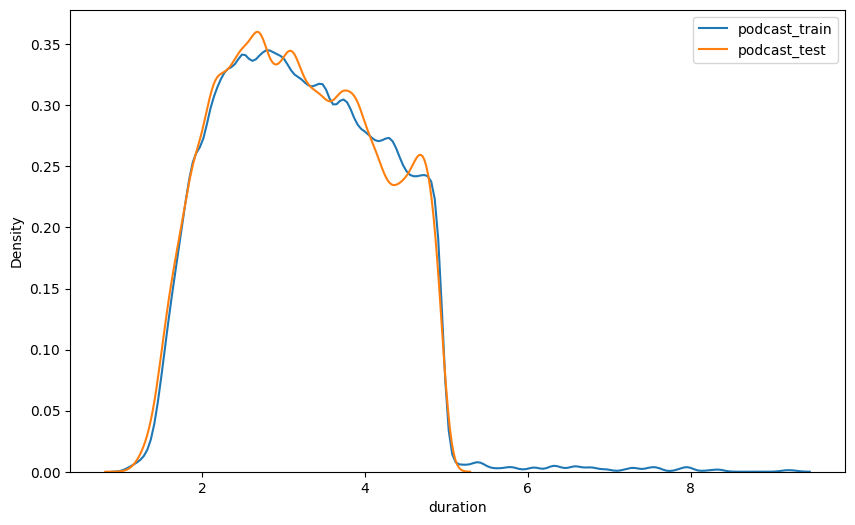

In [142]:
plt.figure(figsize=(10, 6))
# sns.kdeplot(crowd_train['duration'], label='crowd_train')
# sns.kdeplot(crowd_test['duration'], label='crowd_test')
sns.kdeplot(podcast_train['duration'], label='podcast_train')
sns.kdeplot(podcast_test['duration'], label='podcast_test')
plt.legend()

<Axes: xlabel='emotion', ylabel='count'>

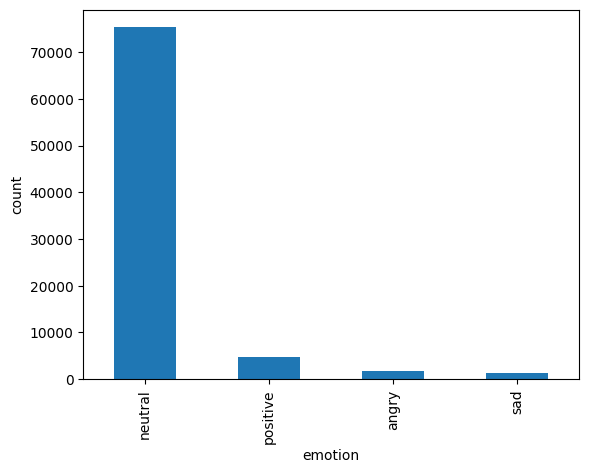

In [ ]:
podcast_test['annotator_emo'].value_counts().plot(kind='bar', xlabel='emotion', ylabel='count')

In [ ]:
def create_waveplot(data, sr, e):
    plt.figure(figsize=(10, 3))
    plt.title('Waveplot for audio with {} emotion'.format(e), size=15)
    librosa.display.waveshow(data, sr=sr)
    plt.show()

def create_spectrogram(data, sr, e):
    X = librosa.stft(data)
    Xdb = librosa.amplitude_to_db(abs(X))
    plt.figure(figsize=(10, 3))
    plt.title('Spectrogram for audio with {} emotion'.format(e), size=15)
    librosa.display.specshow(Xdb, sr=sr, x_axis='time', y_axis='hz', cmap='magma')
    plt.colorbar()

def create_mfcc(data, sr, e):
    plt.figure(figsize=(11, 3))
    mfcc = librosa.feature.mfcc(y=data, sr=sr, hop_length = 512, n_mfcc=13)
    librosa.display.specshow(mfcc, x_axis='time')
    plt.ylabel('MFCC')
    plt.colorbar()
    plt.show()
    plt.plot(np.mean(mfcc.T, axis=0))
    plt.show()
    return mfcc

In [ ]:
podcast_train

,audio_path,duration,annotator_emo,speaker_text
0,wavs/857b7099a4f5766105d166e2283066fa.wav,4.400000,neutral,NaN
1,wavs/2107b749055d85d7c09ac49fd30e3feb.wav,3.800000,neutral,NaN
2,wavs/700b3a5644a0824831848c346d11c7d6.wav,2.500000,neutral,NaN
3,wavs/e8c053899135f139e9527c1388790e36.wav,1.700000,neutral,NaN
4,wavs/7fe59996e0f93b8a63e28aacf480004b.wav,1.900000,neutral,NaN
...,...,...,...,...
645808,wavs/0415f5c556f6588702641ebae32a698a.wav,3.600000,neutral,NaN
645809,wavs/35e8c579de45045fa81376d89dd8877d.wav,4.800000,neutral,NaN
645810,wavs/c75e9fa9f8dfca88dc93fa1e60a82144.wav,4.300000,neutral,NaN
645811,wavs/a82d82a9e4c970dfd8dd483ef603fca4.wav,3.300000,neutral,NaN


In [ ]:
files = [f for f in os.listdir('/content/podcast_train/wavs')]
podcast_train[podcast_train['audio_path'] == 'wavs/'+files[0]].iloc[0]

audio_path       wavs/36073b2cfa2dfae25539e552044da815.wav
duration                                              6.76
annotator_emo                                          sad
speaker_text                                           NaN
Name: 2862, dtype: object

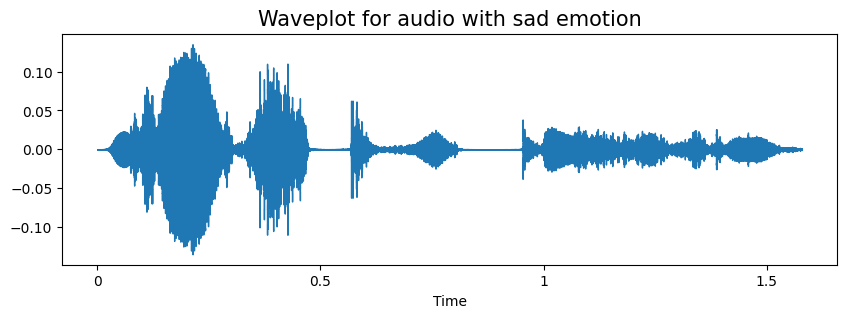

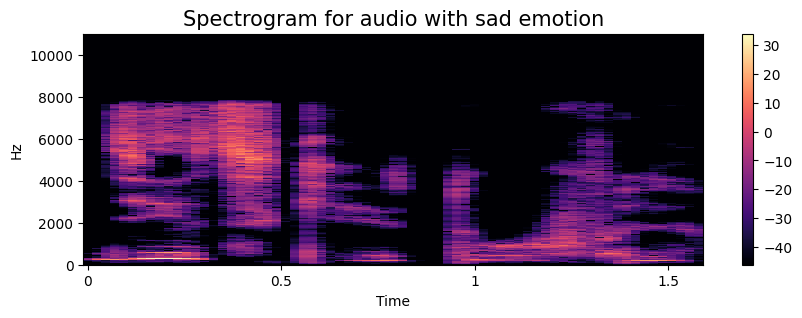

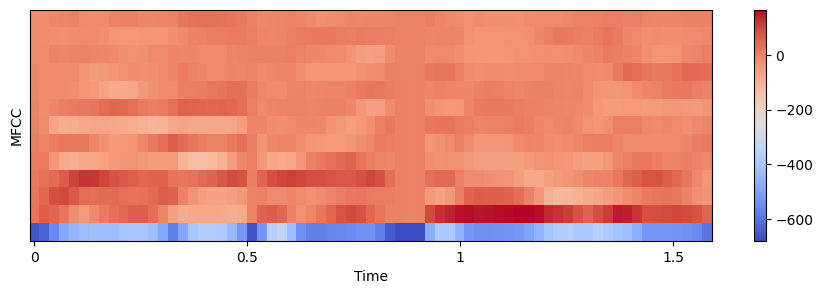

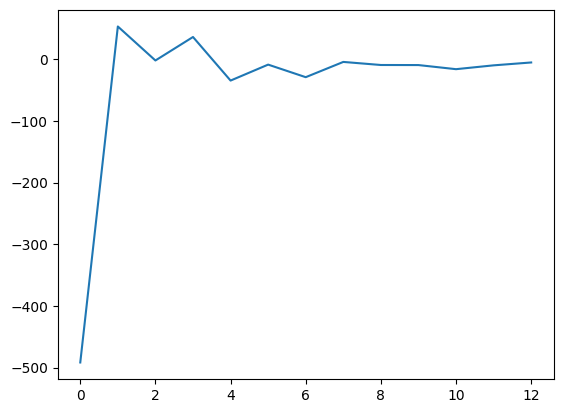

In [ ]:
from os.path import normpath, join


data, sr = librosa.load('/content/podcast_train/wavs/'+files[0])
data = nr.reduce_noise(data, sr=sr)
xt, index = librosa.effects.trim(data, top_db=33)
display(Audio(xt, rate=sr))
create_waveplot(xt, sr, 'sad')
create_spectrogram(xt, sr, 'sad')
mfcc_p = create_mfcc(xt, sr, 'sad')
#Audio(path)

Text(0.5, 1.0, 'Mean MFCC на Crowd, после предобработки')

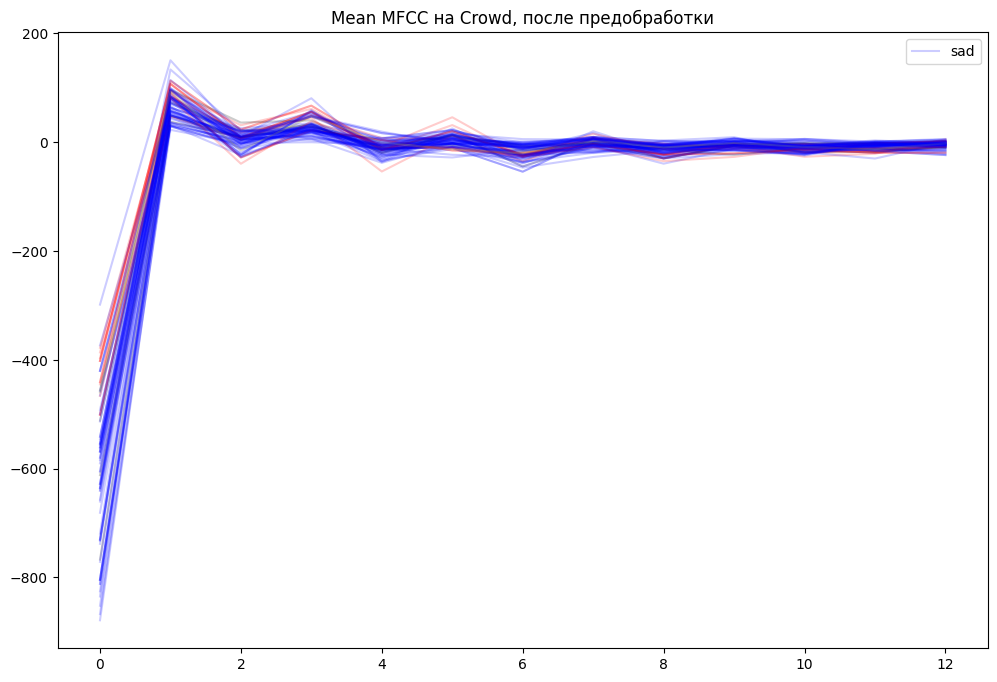

In [139]:
plt.figure(figsize=(12, 8))
colors = ['', 'black', 'yellow', 'blue', '', 'red']
for i in range(200):
    for emo in ['angry', 'positive', 'sad', 'neutral']:
        path = podcast_train[podcast_train['annotator_emo'] == emo]['audio_path'].iloc[i]
        f = path.split('/')[1]
        if f in files:
            data, sr = librosa.load(f'/content/podcast_train/wavs/' + f)
            data = nr.reduce_noise(data, sr=sr)
            data, index = librosa.effects.trim(data, top_db=33)
            mfcc = np.mean(librosa.feature.mfcc(y=data, sr=sr, hop_length = 512, n_mfcc=13), axis=1)
            if i==0:
                plt.plot(mfcc, color=colors[len(emo)%6], alpha=0.2, label=emo)
            else:
                plt.plot(mfcc, color=colors[len(emo)%6], alpha=0.2)
plt.legend()
plt.title('Mean MFCC на Crowd, после предобработки')

###2. Решить задачу классификации классическими методами машинного обучения.

In [ ]:
def get_mfcc(audio_path, dir='crowd_test'):
    data, sr = librosa.load(f'/content/{dir}/' + audio_path)
    mfcc = np.mean(librosa.feature.mfcc(y=data, sr=sr, hop_length = 512, n_mfcc=13), axis=1)
    return mfcc

mapping = {'neutral' : 0, 'sad' : 1, 'positive' : 2, 'angry' : 3}

test_mfcc = pd.DataFrame()
test_mfcc['audio'] = test_unique['audio_path'].apply(get_mfcc, dir='crowd_test')
test_mfcc['class'] = test_unique['annotator_emo'].map(mapping)
test_mfcc['text'] = test_unique['speaker_text']
test_mfcc['audio_path'] = test_unique['audio_path']

In [ ]:
test_mfcc.head()

,audio,class,text,audio_path
0,"[-576.2246, 75.1169, 2.4273312, 38.593025, -12...",0,я слушаю,wavs/9e9961c53ca6eeb440b217e539fbf46c.wav
1,"[-702.62463, 85.39135, 13.58898, 40.735622, -2...",1,каким стал сбер,wavs/0166f65a30354db8282682b1a280e64c.wav
2,"[-526.1417, 81.23312, 0.8175693, 20.244223, -1...",0,где родился шерлок холмс,wavs/d49a6b560155831725a7bdc7d0a96099.wav
3,"[-374.01477, 96.98188, -7.252651, 24.35331, -1...",0,открой в браузере ennio morricone,wavs/c6852b0925797612d7b6724da8cbe7b4.wav
12,"[-430.2097, 32.788387, -23.467474, 9.219417, -...",2,а там и ева проснулись с утра,wavs/64a7aa17132c3e4b7be1aaed5fc88090.wav


In [ ]:
test_mfcc['class'].value_counts()

0    10325
1     3096
3     1921
2     1732
Name: class, dtype: int64

In [ ]:
# compression_opts = dict(method='zip', archive_name='out.csv')
# test_audio_class.to_csv('/content/drive/MyDrive/Colab Notebooks/тексты/6_sound/test_audio_class.zip', compression=compression_opts)

In [ ]:
# from google.colab import files
# files.download('/content/drive/MyDrive/Colab Notebooks/тексты/6_sound/test_audio_class.zip')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [ ]:
# df = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/тексты/6_sound/test_audio_class.csv')
# df.head()

In [ ]:
x = test_mfcc['audio'].tolist()
y = test_mfcc['class'].tolist()

In [ ]:
from sklearn.metrics import classification_report, confusion_matrix

def just_model(model, x_train, y_train, x_test, y_test):
    model.fit(x_train, y_train)

    y_pred = model.predict(x_test)
    print(f'модель : {model}')
    print(classification_report(y_test, y_pred))
    confusion_matrix(y_test, y_pred)
    plt.figure(figsize=(5,3))
    sns_plot = sns.heatmap(confusion_matrix(y_test, y_pred), annot=True, fmt='d')
    plt.show()

In [ ]:
from sklearn import svm, neighbors, tree
from sklearn.neural_network import MLPClassifier
from sklearn.naive_bayes import GaussianNB

# svc = svm.SVC()
# linearSVC = svm.LinearSVC()
# gaussianSVC = svm.SVC(kernel='rbf')
# polynomialSVC = svm.SVC(kernel='poly', degree=8)

nbrs = neighbors.KNeighborsClassifier(n_neighbors=2)
mlp = MLPClassifier(solver='lbfgs')
decision_tree = tree.DecisionTreeClassifier()
gnb = GaussianNB()

models = [nbrs, mlp, decision_tree, gnb]

модель : KNeighborsClassifier(n_neighbors=2)
              precision    recall  f1-score   support

           0       0.67      0.89      0.77      2076
           1       0.42      0.24      0.31       578
           2       0.33      0.18      0.24       373
           3       0.55      0.18      0.27       388

    accuracy                           0.62      3415
   macro avg       0.49      0.37      0.39      3415
weighted avg       0.58      0.62      0.57      3415



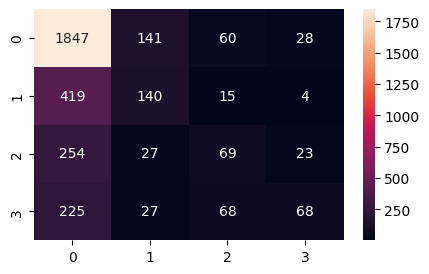

/usr/local/lib/python3.10/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:541: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)


модель : MLPClassifier(solver='lbfgs')
              precision    recall  f1-score   support

           0       0.61      0.99      0.76      2076
           1       0.33      0.00      0.01       578
           2       0.42      0.04      0.07       373
           3       0.43      0.01      0.02       388

    accuracy                           0.61      3415
   macro avg       0.45      0.26      0.21      3415
weighted avg       0.52      0.61      0.47      3415



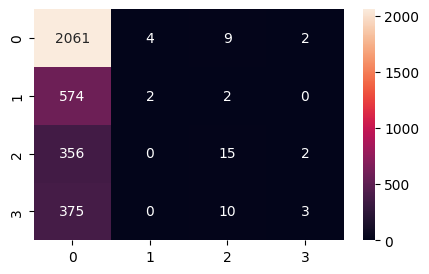

модель : DecisionTreeClassifier()
              precision    recall  f1-score   support

           0       0.68      0.67      0.67      2076
           1       0.30      0.33      0.31       578
           2       0.23      0.23      0.23       373
           3       0.28      0.28      0.28       388

    accuracy                           0.52      3415
   macro avg       0.37      0.37      0.37      3415
weighted avg       0.52      0.52      0.52      3415



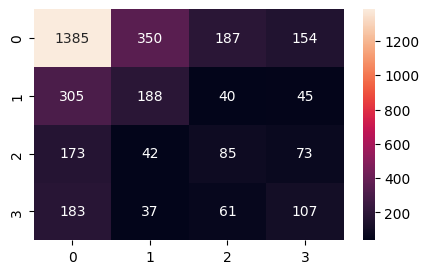

модель : GaussianNB()
              precision    recall  f1-score   support

           0       0.63      0.91      0.75      2076
           1       0.52      0.09      0.16       578
           2       0.22      0.16      0.18       373
           3       0.41      0.07      0.13       388

    accuracy                           0.60      3415
   macro avg       0.45      0.31      0.30      3415
weighted avg       0.54      0.60      0.52      3415



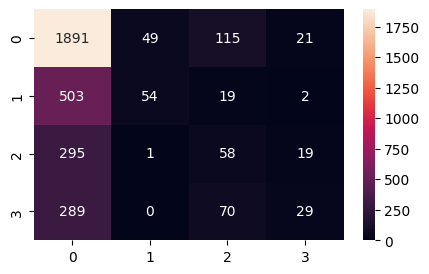

In [ ]:
from sklearn.model_selection import train_test_split

x_train, x_test, y_train, y_test = train_test_split(x, y, train_size=0.8)

for model in models:
    just_model(model, x_train, y_train, x_test, y_test)

###3. Решить задачу классификации, HuBERT. (аудиофайл)

####meh

In [ ]:
# feature_extractor = Wav2Vec2FeatureExtractor.from_pretrained("facebook/hubert-large-ls960-ft")
# model = HubertForSequenceClassification.from_pretrained("xbgoose/hubert-speech-emotion-recognition-russian-dusha-finetuned")
# num2emotion = {0: 'neutral', 1: 'angry', 2: 'positive', 3: 'sad'}

# filepath = "/content/crowd_test/wavs/0004eb46b532c20b2f181f1a65d3ff17.wav"

# def get_audio(filepath, dir='/content/crowd_test'):

#     waveform, sample_rate = torchaudio.load(f'{dir}{filepath}/', normalize=True)
#     transform = torchaudio.transforms.Resample(sample_rate, 16000)
#     waveform = transform(waveform)

#     inputs = feature_extractor(
#             waveform,
#             sampling_rate=feature_extractor.sampling_rate,
#             return_tensors="pt",
#             padding=True,
#             max_length=16000 * 10,
#             truncation=True
#         )

#     return inputs['input_values'][0]

# # logits = model(inputs).logits
# # predictions = torch.argmax(logits, dim=-1)
# # predicted_emotion = num2emotion[predictions.numpy()[0]]
# # print("Настоящая эмоция: sad")
# # print("Предсказанная эмоция:", predicted_emotion)
# # Audio(filepath)

In [ ]:
!pip install datasets

In [ ]:
from transformers import HubertForSequenceClassification, Wav2Vec2FeatureExtractor
import torchaudio
import torch
from datasets import Dataset

In [ ]:
feature_extractor = Wav2Vec2FeatureExtractor.from_pretrained("facebook/hubert-large-ls960-ft")
model = HubertForSequenceClassification.from_pretrained("xbgoose/hubert-speech-emotion-recognition-russian-dusha-finetuned")

def get_audio(row, dir='crowd_test'):
    data, sr = librosa.load(f'/content/{dir}/'+ row['audio_path'])
    row['audio'] = data
    return row

train = Dataset.from_pandas(train_unique).map(get_audio)
test = Dataset.from_pandas(test_unique).map(get_audio)

train_encodings = feature_extractor(list(train["audio"]), sampling_rate=16000, padding=True, return_tensors="pt")
test_encodings = feature_extractor(list(test["audio"]), sampling_rate=16000, padding=True, return_tensors="pt")

# mapping = {'neutral' : 0, 'sad' : 1, 'positive' : 2, 'angry' : 3}


Some weights of the model checkpoint at xbgoose/hubert-speech-emotion-recognition-russian-dusha-finetuned were not used when initializing HubertForSequenceClassification: ['hubert.encoder.pos_conv_embed.conv.weight_v', 'hubert.encoder.pos_conv_embed.conv.weight_g']
- This IS expected if you are initializing HubertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing HubertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of HubertForSequenceClassification were not initialized from the model checkpoint at xbgoose/hubert-speech-emotion-recognition-russian-dusha-finetuned and are newly initialized: ['hubert.encoder.pos_conv_embed.conv.parametri

Map:   0%|          | 0/800 [00:00<?, ? examples/s]

Map:   0%|          | 0/200 [00:00<?, ? examples/s]

In [ ]:
import torch
import torch.nn.functional as F

maxlen = train_audio_class['audio'].apply(len).max()

def to_tensor(x, maxlen):
    l = []
    for i in x.tolist():
        t = torch.tensor([i])
        t = F.pad(t, (maxlen - t.size(1), 0))
        l.append(t)
    return torch.cat(l)

x_tensor_train = to_tensor(train_audio_class['audio'], maxlen)
y_tensor_train = torch.tensor(train_audio_class['class'].tolist())
torch.save(x_tensor_train, '/content/drive/MyDrive/Colab Notebooks/тексты/6_sound/x_tensor_train.t')
torch.save(y_tensor_train, '/content/drive/MyDrive/Colab Notebooks/тексты/6_sound/y_tensor_train.t')

# maxlen = test_audio_class['audio'].apply(len).max()
# x_tensor_test = to_tensor(test_audio_class['audio'], maxlen)
# y_tensor_test = torch.tensor(test_audio_class['class'].tolist())
# torch.save(x_tensor_test, '/content/drive/MyDrive/Colab Notebooks/тексты/6_sound/x_tensor_test.t')
# torch.save(y_tensor_test, '/content/drive/MyDrive/Colab Notebooks/тексты/6_sound/y_tensor_test.t')

<ipython-input-8-b6274a5287eb>:9: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at ../torch/csrc/utils/tensor_new.cpp:261.)
  t = torch.tensor([i])


####moch

In [ ]:
!pip install datasets

In [ ]:
from transformers import HubertForSequenceClassification, Wav2Vec2FeatureExtractor
import torchaudio

from torch.utils.data import TensorDataset, DataLoader

# model = HubertForSequenceClassification.from_pretrained("xbgoose/hubert-speech-emotion-recognition-russian-dusha-finetuned")

In [ ]:
import pickle

with open('/content/drive/MyDrive/Colab Notebooks/тексты/6_sound/sound/raw_train.pkl', 'rb') as f:
    raw_train = pickle.load(f)

with open('/content/drive/MyDrive/Colab Notebooks/тексты/6_sound/sound/raw_test.pkl', 'rb') as f:
    raw_test = pickle.load(f)

with open('/content/drive/MyDrive/Colab Notebooks/тексты/6_sound/sound/labels_train.pkl', 'rb') as f:
    labels_train = pickle.load(f)

with open('/content/drive/MyDrive/Colab Notebooks/тексты/6_sound/sound/labels_test.pkl', 'rb') as f:
    labels_test = pickle.load(f)

In [ ]:
train_dataset = TensorDataset(torch.tensor(raw_train[:800]), torch.tensor(labels_train[:800]))
test_dataset = TensorDataset(torch.tensor(raw_test[:200]), torch.tensor(labels_test[:200]))

train_loader = DataLoader(train_dataset)
test_loader = DataLoader(test_dataset)

<ipython-input-5-a1c3bbf023f4>:1: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at ../torch/csrc/utils/tensor_new.cpp:261.)
  train_dataset = TensorDataset(torch.tensor(raw_train[:800]), torch.tensor(labels_train[:800]))


In [ ]:
for i in train_loader:
    print(i)
    break

[tensor([[ 0.0010,  0.0010,  0.0010,  ...,  0.6694, -0.0881,  0.0330]]), tensor([0])]


In [ ]:
from transformers import HubertForSequenceClassification
from torch.optim import AdamW

# Loading the model
model = HubertForSequenceClassification.from_pretrained("xbgoose/hubert-speech-emotion-recognition-russian-dusha-finetuned")
model.to(device)

# Loading the optimizer
optim = AdamW(model.parameters(), lr=1e-5)

In [ ]:
from tqdm import tqdm

# Prediction function
def predict(outputs):
    probabilities = torch.softmax(outputs["logits"], dim=1)
    predictions = torch.argmax(probabilities, dim=1)
    return predictions

epoch = 3

model.train()

train_loss = list()
train_accuracies = list()
for epoch_i in range(epoch):

    correct = 0
    count = 0
    epoch_loss = list()

    for batch in tqdm(train_loader):
        optim.zero_grad()
        input_ids = batch[0].to(device)
        # attention_mask = batch['attention_mask'].to(device)
        labels = batch[1].to(device)
        outputs = model(input_ids, labels=labels)
        loss = outputs['loss']
        loss.backward()
        optim.step()

        predictions = predict(outputs)

        correct += predictions.eq(labels).sum().item()
        count += len(labels)
        accuracy = correct * 1.0 / count

        epoch_loss.append(loss.item())

    train_loss += epoch_loss
    train_accuracies.append(accuracy)
    print(f'{epoch_i} loss : {epoch_loss}')

 35%|███▌      | 283/800 [1:19:15<2:24:48, 16.80s/it]


KeyboardInterrupt: ignored

In [ ]:
epoch_loss[-10:]

[1.199843168258667,
 0.2198154181241989,
 0.029103245586156845,
 3.2911906242370605,
 0.7254775762557983,
 0.016963504254817963,
 0.08506736904382706,
 0.07272282987833023,
 5.242315292358398,
 0.17381249368190765]

In [ ]:
plt.plot(train_loss, label="Training Loss")
plt.xlabel("Iteration")
plt.ylabel("Loss")
plt.title("Iteration vs Training Loss")
plt.legend()
plt.show()

acc_X = np.arange(len(train_accuracies))+1
plt.plot(acc_X, train_accuracies,"-", label="Training Accuracy")
plt.xticks(acc_X)
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.title("Epoch vs Training Accuracy")
plt.legend()
plt.show()

In [ ]:
model.eval()

with torch.no_grad():

    correct = 0
    count = 0
    record = {"labels":list(), "predictions":list()}

    for batch in tqdm(test_loader):
        input_ids = batch[0].to(device)
        # attention_mask = batch['attention_mask'].to(device)
        labels = batch[1].to(device)
        outputs = model(input_ids, labels=labels)
        loss = outputs['loss']

        predictions = predict(outputs)

        correct += predictions.eq(labels).sum().item()
        count += len(labels)
        accuracy = correct * 1.0 / count

        record["labels"] += labels.cpu().numpy().tolist()
        record["predictions"] += predictions.cpu().numpy().tolist()

print("The final accuracy on the test dataset: %s%%" % round(accuracy*100,4))

In [ ]:
record

{'labels': [0, 1, 0, 0, 0, 1, 0, 3, 0, 1, 1, 3, 0, 0, 0],
 'predictions': [0, 1, 0, 0, 0, 1, 0, 2, 0, 0, 0, 2, 1, 0, 0]}

###4. Разработать систему онлайн записи аудиофайлов и ее транскрибации с использованием Whisper (аудиофайл)
(https://github.com/openai/whisper/)

In [ ]:
!pip install cohere

In [ ]:
!pip install openai

In [ ]:
!pip install git+https://github.com/openai/whisper.git -q

In [ ]:
!pip install ffmpeg

In [ ]:
!pip install setuptools-rust

In [ ]:
import pandas as pd

dff = pd.read_json('/content/podcast_train/raw_podcast_train.jsonl', lines=True)

In [ ]:
import whisper
import os
from tqdm import tqdm

model = whisper.load_model("base")

files = [f for f in os.listdir('/content/podcast_train/wavs')]
result = [model.transcribe('/content/podcast_train/wavs/' + t)['text'] for t in tqdm(files[:100])]

In [ ]:
for i in range(len(files[:10])):
    print(result[i])
    data, sr = librosa.load(f'/content/podcast_train/wavs/' + files[i])
    data = nr.reduce_noise(data, sr=sr)
    xt, index = librosa.effects.trim(data, top_db=33)
    display(Audio(xt, rate=sr))

 Детики и туфли.


 шоу кондитер 4 сезона


 Słuchaj, kłyszmy, kanał.


 Я хочу номер 1.


 molti pianoseri


 Попись к аспорт.


 Вочные котлеты.


 Эльза, Эльза короче говоря.


 Мультик прозаичат на YouTube.


 включи песню с гриптонейта танцуй сама


In [ ]:
len(result)

100

In [ ]:
files_f = ['wavs/' + s for s in files]
ds = dff[dff['audio_path'].isin(files_f[:100])].drop_duplicates(subset=['audio_path'], keep='first')[['annotator_emo', 'audio_path']]
mapping = {'neutral' : 0, 'sad' : 1, 'positive' : 2, 'angry' : 3}
ds['label'] = ds['annotator_emo'].map(mapping).fillna(4)
ds['audio'] = result

In [ ]:
ds.head()

,annotator_emo,audio_path,label,audio
11,sad,wavs/eac47d2886774c3a5fbdc2ff552ce2f1.wav,1.0,Детики и туфли.
19,neutral,wavs/0f6231dcaeb74e5c64b7a52ebea37ef3.wav,0.0,шоу кондитер 4 сезона
37,neutral,wavs/bee2345241659c6f998df4936095cc15.wav,0.0,"Słuchaj, kłyszmy, kanał."
97,sad,wavs/6c0dddce6a86f7fe9c017c03a299773e.wav,1.0,Я хочу номер 1.
270,sad,wavs/5fbc1defc872c91df995dee391a7f7c0.wav,1.0,molti pianoseri


###5. Примените ruBERT для анализа тональности текста (текст полученный с виспера)

####meh

In [ ]:
from datasets import Dataset

data = Dataset.from_pandas(ds[['audio', 'annotator_emo']])

In [ ]:
data['annotator_emo']

In [ ]:
!pip install evaluate

In [ ]:
from transformers import AutoTokenizer

tokenizer = AutoTokenizer.from_pretrained("Den4ikAI/ruBert_base_intent_detection")

def preprocess_function(examples):
    return tokenizer(examples["audio"], truncation=True)

tokenized_imdb = data.map(preprocess_function, batched=True)

Map:   0%|          | 0/100 [00:00<?, ? examples/s]

Asking to truncate to max_length but no maximum length is provided and the model has no predefined maximum length. Default to no truncation.


In [ ]:
label2id = {'neutral' : 0, 'sad' : 1, 'positive' : 2, 'angry' : 3, 'other' : 4}
id2label = {val: key for key, val in label2id.items()}

In [ ]:
from transformers import DataCollatorWithPadding
import evaluate

data_collator = DataCollatorWithPadding(tokenizer=tokenizer)
accuracy = evaluate.load("accuracy")

def compute_metrics(eval_pred):
    predictions, labels = eval_pred
    predictions = np.argmax(predictions, axis=1)
    return accuracy.compute(predictions=predictions, references=labels)

In [ ]:
!pip install accelerate -U

In [ ]:
! pip install -U transformers

In [ ]:
from transformers import AutoModelForSequenceClassification, TrainingArguments, Trainer

model = AutoModelForSequenceClassification.from_pretrained(
    "Den4ikAI/ruBert_base_intent_detection", ignore_mismatched_sizes=True, num_labels=5, id2label=id2label, label2id=label2id)

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at Den4ikAI/ruBert_base_intent_detection and are newly initialized because the shapes did not match:
- classifier.bias: found shape torch.Size([60]) in the checkpoint and torch.Size([5]) in the model instantiated
- classifier.weight: found shape torch.Size([60, 768]) in the checkpoint and torch.Size([5, 768]) in the model instantiated
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [ ]:
training_args = TrainingArguments(
    output_dir="my_awesome_model",
    learning_rate=2e-5,
    per_device_train_batch_size=16,
    per_device_eval_batch_size=16,
    num_train_epochs=2,
    weight_decay=0.01,
    evaluation_strategy="epoch",
    save_strategy="epoch",
    load_best_model_at_end=True,
)

trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=tokenized_imdb["audio"],
    eval_dataset=tokenized_imdb["annotator_emo"],
    tokenizer=tokenizer,
    data_collator=data_collator,
    compute_metrics=compute_metrics,
)

trainer.train()

You're using a BertTokenizerFast tokenizer. Please note that with a fast tokenizer, using the `__call__` method is faster than using a method to encode the text followed by a call to the `pad` method to get a padded encoding.


AttributeError: ignored

####moch

In [ ]:
from torch.utils.data import Dataset, DataLoader
from transformers import BertModel, BertTokenizer, BertForSequenceClassification
from torch.optim import AdamW
from transformers import get_linear_schedule_with_warmup

In [ ]:
class CustomDataset(Dataset):

  def __init__(self, texts, targets, tokenizer, max_len=512):
    self.texts = texts
    self.targets = targets
    self.tokenizer = tokenizer
    self.max_len = max_len

  def __len__(self):
    return len(self.texts)

  def __getitem__(self, idx):
    print(idx)
    text = str(self.texts[idx])
    target = self.targets[idx]

    encoding = self.tokenizer.encode_plus(
        text,
        add_special_tokens=True,
        max_length=self.max_len,
        return_token_type_ids=False,
        padding='max_length',
        return_attention_mask=True,
        return_tensors='pt',
    )

    return {
      'text': text,
      'input_ids': encoding['input_ids'].flatten()[:512],
      'attention_mask': encoding['attention_mask'].flatten()[:512],
      'targets': torch.tensor(target, dtype=torch.long)
    }

In [ ]:
class BertClassifier:
    def __init__(self, model_path, tokenizer_path, n_classes=2, epochs=1, model_save_path='/content/bert.pt'):
        self.model = BertForSequenceClassification.from_pretrained(model_path)
        self.tokenizer = BertTokenizer.from_pretrained(tokenizer_path)
        self.device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
        self.model_save_path=model_save_path
        self.max_len = 512
        self.epochs = epochs
        self.out_features = self.model.bert.encoder.layer[1].output.dense.out_features
        self.model.classifier = torch.nn.Linear(self.out_features, n_classes)
        self.model.to(self.device)

    def preparation(self, X_train, y_train, X_valid, y_valid):
        # create datasets
        self.train_set = CustomDataset(X_train, y_train, self.tokenizer)
        self.valid_set = CustomDataset(X_valid, y_valid, self.tokenizer)

        # create data loaders
        self.train_loader = DataLoader(self.train_set, batch_size=2, shuffle=True)
        self.valid_loader = DataLoader(self.valid_set, batch_size=2, shuffle=True)

        # helpers initialization
        self.optimizer = AdamW(self.model.parameters(), lr=2e-5)
        self.scheduler = get_linear_schedule_with_warmup(
                self.optimizer,
                num_warmup_steps=0,
                num_training_steps=len(self.train_loader) * self.epochs
            )
        self.loss_fn = torch.nn.CrossEntropyLoss().to(self.device)

    def eval(self):
        self.model = self.model.eval()
        losses = []
        correct_predictions = 0

        with torch.no_grad():
            for data in self.valid_loader:
                input_ids = data["input_ids"].to(self.device)
                attention_mask = data["attention_mask"].to(self.device)
                targets = data["targets"].to(self.device)

                outputs = self.model(
                    input_ids=input_ids,
                    attention_mask=attention_mask
                    )

                preds = torch.argmax(outputs.logits, dim=1)
                loss = self.loss_fn(outputs.logits, targets)
                correct_predictions += torch.sum(preds == targets)
                losses.append(loss.item())

        val_acc = correct_predictions.double() / len(self.valid_set)
        val_loss = np.mean(losses)
        return val_acc, val_loss

    def fit(self):
        self.model = self.model.train()
        losses = []
        correct_predictions = 0

        for data in tqdm(self.train_loader):
            input_ids = data["input_ids"].to(self.device)
            attention_mask = data["attention_mask"].to(self.device)
            targets = data["targets"].to(self.device)

            outputs = self.model(
                input_ids=input_ids,
                attention_mask=attention_mask
                )

            preds = torch.argmax(outputs.logits, dim=1)
            loss = self.loss_fn(outputs.logits, targets)

            correct_predictions += torch.sum(preds == targets)

            losses.append(loss.item())

            loss.backward()
            torch.nn.utils.clip_grad_norm_(self.model.parameters(), max_norm=1.0)
            self.optimizer.step()
            self.scheduler.step()
            self.optimizer.zero_grad()

        train_acc = correct_predictions.double() / len(self.train_set)
        train_loss = np.mean(losses)
        return train_acc, train_loss

    def predict(self, text):
        encoding = self.tokenizer.encode_plus(
            text,
            add_special_tokens=True,
            max_length=self.max_len,
            return_token_type_ids=False,
            truncation=True,
            padding='max_length',
            return_attention_mask=True,
            return_tensors='pt',
        )

        out = {
            'text': text,
            'input_ids': encoding['input_ids'].flatten(),
            'attention_mask': encoding['attention_mask'].flatten()
        }

        input_ids = out["input_ids"].to(self.device)
        attention_mask = out["attention_mask"].to(self.device)

        outputs = self.model(
            input_ids=input_ids.unsqueeze(0),
            attention_mask=attention_mask.unsqueeze(0)
        )

        prediction = torch.argmax(outputs.logits, dim=1).cpu().numpy()[0]

        return prediction

    def train(self):
        best_accuracy = 0
        for epoch in range(self.epochs):
            print(f'Epoch {epoch + 1}/{self.epochs}')
            train_acc, train_loss = self.fit()
            print(f'Train loss {train_loss} accuracy {train_acc}')

            val_acc, val_loss = self.eval()
            print(f'Val loss {val_loss} accuracy {val_acc}')
            print('-' * 10)

            if val_acc > best_accuracy:
                torch.save(self.model, self.model_save_path)
                best_accuracy = val_acc

        self.model = torch.load(self.model_save_path)



####out

In [ ]:
from torch.utils.data import DataLoader
from torch.optim import AdamW
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(ds['audio'].tolist(), ds['label'].tolist(),
                                                    train_size=0.8, random_state=42)

print(len(X_train), len(y_train))
print(len(X_test), len(y_test))

model_path = "cointegrated/rubert-tiny"

help = BertClassifier('cointegrated/rubert-tiny', 'cointegrated/rubert-tiny', epochs=3)

help.preparation(X_train, y_train, X_test, y_test)
help.train()

80 80
20 20


Some weights of BertForSequenceClassification were not initialized from the model checkpoint at cointegrated/rubert-tiny and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch 1/3


  0%|          | 0/40 [00:00<?, ?it/s]

[44, 6]


TypeError: ignored